In [ ]:
# Connect to Github Data Repo
!git clone https://github.com/verma-aniket/CEE_266G_Data_Repo GitRepo

# Set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

Cloning into 'GitRepo'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (36/36), 732.65 KiB | 2.61 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
!pip install cvxpy

In [ ]:
# Import required libraries
import cvxpy as cvx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


#  LP Formulation of Melbourne Water Supply

Melbourne Water would like to minimize the total cost of supplying water from 2000 to 2014 while meeting 100% of water demand. As before, water supply can come from three sources: net inflows, desalinated water, and pipeline water. Net inflows and the maximum availability, both in MCM, have already been read from “net_inflow.csv” and “pipeline_availability.csv”, respectively. The maximum capacity of the desalination plant is 150 MCM. It costs \$0.45 per m3 to supply desalinated water and \$0.28 per m3 to import water from the pipeline.


The reservoir capacity is 1812 MCM. Reservoir storage starts in the year 2000 at 600 MCM. The reservoir can never go below 580 MCM.  Water demand varies each year.


In [ ]:
# Import data
# All units in MCM
data = pd.read_csv('net_inflow.csv', header=None, names=['Year', 'Inflow'])
data = data[data['Year']>=2000]
pipeline = np.loadtxt('pipeline_availability.csv', delimiter=',')
demand = np.loadtxt('demand.csv', delimiter=',')
data['Pipeline'] = pipeline[:,1]
data['Demand'] = demand[:,1]
data = data[data['Year']<=2015]
del demand, pipeline
data.set_index('Year', inplace = True)
print(data)

# Parameters
desalCapacity = 150 # [MCM]
K = 1812 # reservoir capacity [MCM]
K0 = 600 # initial storage capacity [MCM]
minK = 580 # minimum storage level [MCM]
KT = 600 # final storage capacity [MCM] (leave reservoir as full as it started)
pipelineCost = 0.28 * 10**6 # $ per MCM
desalCost = 0.45 * 10**6 # $ per MCM

      Inflow  Pipeline  Demand
Year                          
2000     560     172.0   518.0
2001     426     189.0   548.0
2002     324     124.0   570.0
2003     509     219.0   530.0
2004     508     229.0   530.0
2005     389     145.0   557.0
2006     163      65.0   608.0
2007     374     107.0   560.0
2008     287      79.0   579.0
2009     369     164.0   561.0
2010     559     200.0   518.0
2011     634     245.0   501.0
2012     658     194.0   495.0
2013     416     142.0   551.0
2014     421     119.0   549.0
2015      36      10.0   636.0



*Min* $Cost = P \times PipelineCost + D \times DesalCost$  
*s.t*  
$S[t + 1] = S[t] - R[t] + I[t] + P[t] + D[t], ∀ t= 0,1, ..., T-2$  
$S[0] = K_{0}$  
$S[T] = KT$  
$S[t] \leqslant K, ∀ t= 0,1, ..., T-1$  
$S[t] \geqslant minK, ∀ t= 0,1, ..., T-1$  
$R[t] \geqslant Demand[t], ∀ t= 0,1, ..., T-1$  
$P[t] \leqslant Pipeline[t], ∀ t= 0,1, ..., T-1$  
$D[t] \leqslant desalCapacity, ∀ t= 0,1, ..., T-1$  
$S[t],R[t],P[t],D[t] \geqslant 0, ∀ t= 0,1, ..., T-1$  
where $S$ is storage, $R$ is release, $P$ is imported pipeline water, $D$ is imported desal water, $I$ is inflow.  

The decsion variables are S, R, P and D.

Solution status: optimal
Optimal objective value: 633469999.9251015
Optimal values of storage DVs: [ 600.          827.88914461  909.45623343  801.87997321 1014.73165242
 1236.62404532 1227.82605131  861.30409481  796.1226335   597.57554075
  580.00000002  747.28046815 1017.80902066 1285.99023481 1238.77728832
 1194.3671999 ]
Optimal values of release DVs: [517.99999998 547.99999998 569.99999998 529.99999998 529.99999998
 556.99999998 607.99999998 559.99999998 578.99999998 560.99999998
 517.99999999 501.         495.         551.         549.
 635.99999999]
Optimal values of pipeline DVs: [172.         189.         124.         218.99999999 229.
 145.          65.00000001 107.          79.00000001 163.99999997
 126.28046813 137.5285525  105.18121415  87.7870535   83.58991158
   5.63280009]
Optimal values of desal DVs: [1.38891446e+01 1.45670888e+01 1.44237398e+01 1.48516792e+01
 1.48923929e+01 1.42020060e+01 1.34780435e+01 1.38185387e+01
 1.44529072e+01 1.04244593e+01 4.30376563e-09 5.

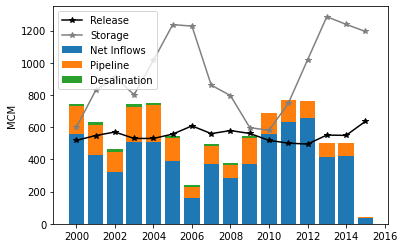

In [ ]:
# %% Formulate Problem

# Number of time periods
T = 2015 - 2000 + 1
years = np.arange(2000, 2015)

# Create a vector S of storage decision variables for each time period
S = cvx.Variable(T)

# Create a vector R of releases each time period
R = cvx.Variable(T)

# Create a vector P of pipeline water imports in each t
P = cvx.Variable(T)

# Create a vector D of desal water imports in each t
D = cvx.Variable(T)

# Create  list of constraints
constraints = []

# Add initial storage constraint
constraints += [S[0] == K0]

# Loop over time range and add constraints that apply in all time periods
for t in range(T):

    # Add water balance constraints
    if t < T-1:
        constraints += [
            S[t + 1] == S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t]
        ]
    else:
        # last time period (because we have a specific constraint for last time period)
        constraints += [
            S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t] == KT
        ]

    # Add storage capacity constraints
    constraints += [
        S[t] <= K,  # Storage can't be above capacity
        S[t] >= minK # Storage can't go below minimum threshold
    ]

    # Add reliability constraints
    constraints += [
        R[t] >= data['Demand'].iloc[t]
    ]

    # Add pipeline and desal availability constraints
    constraints += [
        P[t] <= data['Pipeline'].iloc[t],
        D[t] <= desalCapacity
    ]

    # Add non-negativity constraints
    constraints += [
        S[t] >= 0, R[t] >= 0, P[t] >= 0, D[t] >= 0
    ]

# Create objective function (Minimize total cost of imported water)
objective = cvx.Minimize(cvx.sum(P) * pipelineCost +
                         cvx.sum(D) * desalCost)

# %% Solve LP
prob = cvx.Problem(objective, constraints)
prob.solve()
print("Solution status: " + prob.status) # status is optimal, infeasible, or unbounded
print("Optimal objective value: {}".format(prob.objective.value))
print("Optimal values of storage DVs: {}".format(S.value))
print("Optimal values of release DVs: {}".format(R.value))
print("Optimal values of pipeline DVs: {}".format(P.value))
print("Optimal values of desal DVs: {}".format(D.value))

# Don't continue with analysis of results unless optimal solution found
if(prob.status != 'optimal'):
    sys.exit() # end program because no optimal solution was found

# %% Check and Plot Water Balance

# Calculate water balance
deltaS = np.diff(np.append(S.value, KT))
supply = data['Inflow'] + P.value + D.value
balance = deltaS - supply + R.value

# Verify that water balance is zero
if np.abs(sum(balance)) > 0.1:
    raise Exception("Water balance does not sum to zero")

# Plot water supply and demand
plt.figure()
plt.bar(data.index, data['Inflow'], label='Net Inflows')
plt.bar(data.index, P.value, label='Pipeline', bottom=data['Inflow'])
plt.bar(data.index, D.value, label='Desalination', bottom=data['Inflow'] + P.value)
plt.plot(data.index, R.value, 'k*-', label='Release')
plt.plot(data.index, S.value, '*-', c='gray', label='Storage')
plt.legend()
plt.ylabel('MCM')
plt.show()


Storage constraint scenarios:
1.   Change the minimum storage threshold to 0. How does the optimal objective value and the water supply portfolio change (from Part A) and why?
2.   Reset the minimum storage threshold to 580 MCM. Now, change the final storage volume to be 1500 MCM in 2016. What is the result of the LP? Why?

For full credit, your explanation of “why” must include both a physical description of what is happening in the problem and also a description of what is happening in the LP using LP terminology. For Case 1 specifically, make a plot of the water supply portfolio and qualitatively interpret it.

In [ ]:
# Create LP formulation function

def LP_Formulation(minK,KT):

  # Number of time periods
  T = 2015 - 2000 + 1
  years = np.arange(2000, 2015)

  # Create a vector S of storage decision variables for each time period
  S = cvx.Variable(T)

  # Create a vector R of releases each time period
  R = cvx.Variable(T)

  # Create a vector P of pipeline water imports in each t
  P = cvx.Variable(T)

  # Create a vector D of desal water imports in each t
  D = cvx.Variable(T)

  # Create  list of constraints
  constraints = []

  # Add initial storage constraint
  constraints += [S[0] == K0]

  # Loop over time range and add constraints that apply in all time periods
  for t in range(T):

      # Add water balance constraints
      if t < T-1:
          constraints += [
              S[t + 1] == S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t]
          ]
      else:
          # last time period (because we have a specific constraint for last time period)
          constraints += [
              S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t] == KT
          ]

      # Add storage capacity constraints
      constraints += [
          S[t] <= K,  # Storage can't be above capacity
          S[t] >= minK # Storage can't go below minimum threshold
      ]

      # Add reliability constraints
      constraints += [
          R[t] >= data['Demand'].iloc[t]
      ]

      # Add pipeline and desal availability constraints
      constraints += [
          P[t] <= data['Pipeline'].iloc[t],
          D[t] <= desalCapacity
      ]

      # Add non-negativity constraints
      constraints += [
          S[t] >= 0, R[t] >= 0, P[t] >= 0, D[t] >= 0
      ]

  # Create objective function (Minimize total cost of imported water)
  objective = cvx.Minimize(cvx.sum(P) * pipelineCost +
                          cvx.sum(D) * desalCost)

  # %% Solve LP
  prob = cvx.Problem(objective, constraints)
  prob.solve()
  print("Solution status: " + prob.status) # status is optimal, infeasible, or unbounded
  print("Optimal objective value: {}".format(prob.objective.value))
  print("Optimal values of storage DVs: {}".format(S.value))
  print("Optimal values of release DVs: {}".format(R.value))
  print("Optimal values of pipeline DVs: {}".format(P.value))
  print("Optimal values of desal DVs: {}".format(D.value))

  # Don't continue with analysis of results unless optimal solution found
  if(prob.status != 'optimal'):
      sys.exit() # end program because no optimal solution was found

  return S,R,P,D


Solution status: optimal
Optimal objective value: 609839999.9439557
Optimal values of storage DVs: [ 600.          798.5539892   849.47936945  711.938536    892.40579882
 1082.26921447 1045.51413413  656.95841051  568.7394224   345.3041303
  300.43874134  524.46383632  887.60028506 1226.80641991 1215.57012752
 1194.52688601]
Optimal values of release DVs: [518.         548.         570.00000001 530.         530.
 557.00000001 608.00000003 560.00000002 579.00000002 561.00000001
 518.         501.         495.         551.         549.00000001
 636.        ]
Optimal values of pipeline DVs: [156.55398923 172.92538028 108.45916659 201.46726287 211.86341571
 131.24491972  56.44427644  97.78101195  68.56470796 147.13461109
 183.02509502 230.13644878 176.2061349  123.76370766 106.95675853
   5.47311401]
Optimal values of desal DVs: [-2.34274620e-08 -2.60462164e-08 -2.77537997e-08 -4.47276701e-08
 -5.39594804e-08 -4.69439384e-08 -2.86537212e-08 -3.11072471e-08
 -3.78482003e-08 -3.98206961e-08 

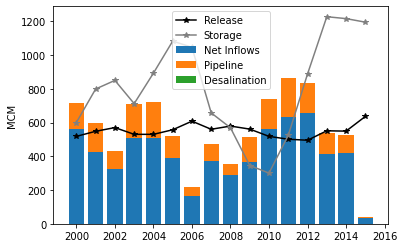

In [ ]:
# Run the LP function for Case 1

S_1,R_1,P_1,D_1=LP_Formulation(0,KT)
plt.figure()
plt.bar(data.index, data['Inflow'], label='Net Inflows')
plt.bar(data.index, P_1.value, label='Pipeline', bottom=data['Inflow'])
plt.bar(data.index, D_1.value, label='Desalination', bottom=data['Inflow'] + P_1.value)
plt.plot(data.index, R_1.value, 'k*-', label='Release')
plt.plot(data.index, S_1.value, '*-', c='gray', label='Storage')
plt.legend()
plt.ylabel('MCM')
plt.show()



**Physical change description:**  
For case 1, a reduction in optimal objective value (633.5 million to 609.8 millon dollars) was occurred, indicating an improvement in objective function. For water supply portfolio, net inflows remain the same. Pipeline water imports are slightly fewer than that in the original case from 2000 to 2009, while are significantly larger since 2010 till 2015. Notably, there is an overall increase (2039 MCM – 2178 MCM) in the sum of pipeline water imports in case 1. Desal water is not imported in any time period in case 1, leaving an overall decrease (139 MCM – 0 MCM) in the cost of desal water usage. Given the high price of the desal cost per unit, the objective variable(cost) decreases.  
**Reasoning:**  
Since there is no longer a threshold for minimum storage level, during the initial dry years, the system can meet the demand and meanwhile minimize the cost by using water in storage (free), thereby reducing the demand for pipeline water and not relying on desal water (expensive). As the storage water is gradually depleted, the water supply switched to relies on merely inflow and pipeline to recharge and fulfill the demand, resulting in the increase in pipeline imports. Meanwhile, imports from desal water (expensive) are also strategically avoided, as the inflows and pipeline imports are adequate in the wet years.  
**Changes in LP:**   
In linear programming, the constraint regarding the minimum storage level, specifically,  S[t] >= minK,could be removed. This expanded the area for feasible solution region，thus a more optimal solution are found.  

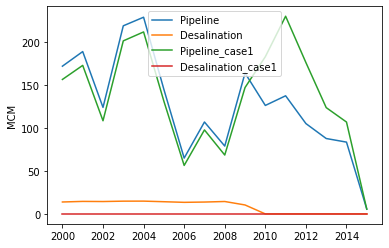

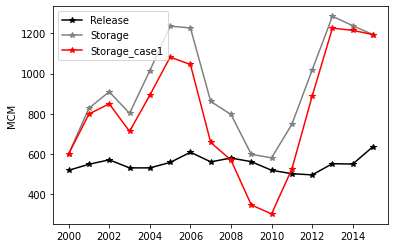

In [ ]:
plt.figure()

plt.plot(data.index, P.value, label='Pipeline')
plt.plot(data.index, D.value, label='Desalination')
plt.plot(data.index, P_1.value, label='Pipeline_case1')
plt.plot(data.index, D_1.value, label='Desalination_case1')
plt.legend()
plt.ylabel('MCM')
plt.show()

plt.figure()
plt.plot(data.index, R.value, 'k*-', label='Release')
plt.plot(data.index, S.value, '*-', c='gray', label='Storage')
plt.plot(data.index, S_1.value, '*-', c='red', label='Storage_case1')
plt.legend()
plt.ylabel('MCM')
plt.show()


In [ ]:
# Run the LP function for Case 2
LP_Formulation(580,1500)

Solution status: infeasible
Optimal objective value: None
Optimal values of storage DVs: None
Optimal values of release DVs: None
Optimal values of pipeline DVs: None
Optimal values of desal DVs: None


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


The result of LP is infeasible to find the minimize cost, as it is impossible to meet one of the constraint (final storage volume) of the LP. The  reservoir capacity [MCM]is only 1812 MCM. Even if we strategically manage the storage in 2015 to reach the maximum (1812 MCM), the max storage volume could be reached in 2016 is only 1372 MCM by minimizing demand, maximizing pipeline & desal imports.  
(1812- data['Demand'].iloc[15] + data['Inflow'].iloc[15] + data['Pipeline'].iloc[15] + desalCapacity)  
Hence, there is no way for storage volume to end up in 1500 MCM. Using LP terminology, the feasible region of solution no longer exist, thus there is no optimal solution.  

# Reformulate the LP to have only equality constraints by adding slack and surplus variables.


*Min* $Cost = P \times PipelineCost + D \times DesalCost$  
*s.t*  
$S[t + 1] = S[t] - R[t] + I[t] + P[t] + D[t], ∀ t= 0,1, ..., T-2$ \
$S[0] = K_{0}$  
$S[T] = KT$  
$S[t] + slack_s[t] = K, ∀ t= 0,1, ..., T-1$  
$S[t] - surplus_s[t] = minK, ∀ t= 0,1, ..., T-1$  
$R[t] - surplus_r[t] = Demand[t], ∀ t= 0,1, ..., T-1$  
$P[t] + slack_p[t] = Pipeline[t], ∀ t= 0,1, ..., T-1$  
$D[t] + slack_d[t] = desalCapacity, ∀ t= 10,1, ..., T-1$  
$S[t],R[t],P[t],D[t],slack_s[t],surplus_s[t],surplus_r[t],slack_p[t],slack_d[t]\geqslant 0, ∀ t= 0,1, ..., T-1$  
where $S$ is storage, $R$ is release, $P$ is imported pipeline water, $D$ is imported desal water, $I$ is inflow, slack_s[t],slack_p[t],slack_d[t] are slack slack variables, surplus_s[t] and surplus_r[t] are surplse variables.



In [ ]:
# reformulate LP by adding slack and surplus variables

def Equal_LP_Formulation(minK,KT):

  # Number of time periods
  T = 2015 - 2000 + 1
  years = np.arange(2000, 2015)

  # Create a vector S of storage decision variables for each time period
  S = cvx.Variable(T)

  # Create a vector R of releases each time period
  R = cvx.Variable(T)

  # Create a vector P of pipeline water imports in each t
  P = cvx.Variable(T)

  # Create a vector D of desal water imports in each t
  D = cvx.Variable(T)

  # Create a series of slack & surplus variables in each t
  slack_s = cvx.Variable(T)
  surplus_s = cvx.Variable(T)
  slack_p = cvx.Variable(T)
  slack_d = cvx.Variable(T)
  surplus_r = cvx.Variable(T)

  # Create  list of constraints
  constraints = []

  # Add initial storage constraint
  constraints += [S[0] == K0]

  # Loop over time range and add constraints that apply in all time periods
  for t in range(T):

      # Add water balance constraints
      if t < T-1:
          constraints += [
              S[t + 1] == S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t]
          ]
      else:
          # last time period (because we have a specific constraint for last time period)
          constraints += [
              S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t] == KT
          ]

      # Add storage capacity constraints
      constraints += [
          S[t] + slack_s[t] == K,  # Storage can't be above capacity
          S[t] - surplus_s[t] == minK # Storage can't go below minimum threshold
      ]

      # Add reliability constraints
      constraints += [
          R[t] - surplus_r[t]== data['Demand'].iloc[t]
      ]

      # Add pipeline and desal availability constraints
      constraints += [
          P[t] + slack_p[t] == data['Pipeline'].iloc[t],
          D[t] + slack_d[t] == desalCapacity
      ]

      # Add non-negativity constraints
      constraints += [
          S[t] >= 0, R[t] >= 0, P[t] >= 0, D[t] >= 0, slack_s[t]>= 0, surplus_s[t]>= 0,  slack_p[t] >= 0, slack_d[t] >= 0, surplus_r[t] >= 0
      ]

  # Create objective function (Minimize total cost of imported water)
  objective = cvx.Minimize(cvx.sum(P) * pipelineCost +
                          cvx.sum(D) * desalCost)

  # %% Solve LP
  prob = cvx.Problem(objective, constraints)
  prob.solve()
  print("Solution status: " + prob.status) # status is optimal, infeasible, or unbounded
  print("Optimal objective value: {}".format(prob.objective.value))
  print("Optimal values of storage DVs: {}".format(S.value))
  print("Optimal values of release DVs: {}".format(R.value))
  print("Optimal values of pipeline DVs: {}".format(P.value))
  print("Optimal values of desal DVs: {}".format(D.value))

  # Report the optimal values of all of the slack and surplus variables
  print("Slack variables in storage: {}".format(slack_s.value))
  print("Surplus variables in storage: {}".format(surplus_s.value))
  print("Slack variables in Pipeline: {}".format(slack_p.value))
  print("Slack variables in desal: {}".format(slack_d.value))
  print("Surplus variables in release: {}".format(surplus_r.value))

  # Don't continue with analysis of results unless optimal solution found
  if(prob.status != 'optimal'):
      sys.exit() # end program because no optimal solution was found

  return S,R,P,D


Solution status: optimal
Optimal objective value: 633469992.2853085
Optimal values of storage DVs: [ 600.          828.57156286  909.28117643  800.85767622 1010.79085108
 1230.05148515 1221.3947673   858.40219497  795.68552825  598.49028301
  580.00000252  748.01487541 1016.28153234 1281.14625935 1235.71618237
 1193.32481492]
Optimal values of release DVs: [517.99999848 547.9999985  569.99999851 529.99999853 529.99999852
 556.9999985  607.99999852 559.9999985  578.99999852 560.99999844
 517.99999917 500.99999939 494.99999938 550.99999909 548.99999905
 635.9999992 ]
Optimal values of pipeline DVs: [172.00000046 189.00000024 124.0000004  218.99999911 228.99999958
 145.00000042  65.00000053 107.00000057  79.00000055 163.99999791
 127.01487223 135.2666566  101.86472666  89.56992226  85.60863158
   6.67518413]
Optimal values of desal DVs: [ 1.45715609e+01  1.37096118e+01  1.35764979e+01  1.19331743e+01
  1.22606330e+01  1.43432802e+01  1.70074257e+01  1.62833312e+01
  1.58047527e+01  9.5097

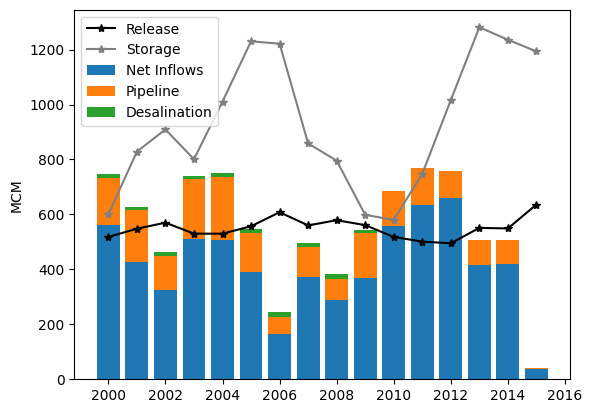

In [ ]:
S_E,R_E,P_E,D_E=Equal_LP_Formulation(580,600)
plt.figure()
plt.bar(data.index, data['Inflow'], label='Net Inflows')
plt.bar(data.index, P_E.value, label='Pipeline', bottom=data['Inflow'])
plt.bar(data.index, D_E.value, label='Desalination', bottom=data['Inflow'] + P_E.value)
plt.plot(data.index, R_E.value, 'k*-', label='Release')
plt.plot(data.index, S_E.value, '*-', c='gray', label='Storage')
plt.legend()
plt.ylabel('MCM')
plt.show()


**Method 1: using constraints**  

*Min* $Cost = P \times PipelineCost + D \times DesalCost$  
*s.t*  
$S[t + 1] = S[t] - R[t] + I[t] + P[t] + D[t], ∀ t= 0,1, ..., T-2$  
$S[0] = K_{0}$  
$S[T] = KT$  
$S[t] \leqslant K, ∀ t= 0,1, ..., T-1$
$S[t] \geqslant minK, ∀ t= 0,1, ..., T-1$  
$R[t] \geqslant c \cdot Demand[t], c\in [0,1], ∀ t= 0,1, ..., T-1$  
$P[t] \leqslant Pipeline[t], ∀ t= 0,1, ..., T-1$  
$D[t] \leqslant desalCapacity, ∀ t= 0,1, ..., T-1$  
$S[t],R[t],P[t],D[t] \geqslant 0, ∀ t= 0,1, ..., T-1$  
where $S$ is storage, $R$ is release, $P$ is imported pipeline water, $D$ is imported desal water, $I$ is inflow.  

Water supply shortages could be mediated via adjusting c to impose different level of targets, and form the result pareto frontier.  

**Pros:** The level of water supply shortages can be directly mediated, by specifying the manitude of c.  
**Cons:** The priority of minimizing cost (primary goal) is higher than that of water supply shortages (secondary goal). The function is not favored if mitigating water supply shortages is the top priority.
  
  
**Method 2: using objective funtion**  

*Min* $ w \cdot Cost +（1-w)\cdot (demand[t])-R[t])$  

*s.t*  
$S[t + 1] = S[t] - R[t] + I[t] + P[t] + D[t], ∀ t= 0,1, ..., T-2$  
$S[0] = K_{0}$  
$S[T] = KT$  
$S[t] \leqslant K, ∀ t= 0,1, ..., T-1$  
$S[t] \geqslant minK, ∀ t= 0,1, ..., T-1$  
$P[t] \leqslant Pipeline[t], ∀ t= 0,1, ..., T-1$  
$D[t] \leqslant desalCapacity, ∀ t= 0,1, ..., T-1$  
$S[t],R[t],P[t],D[t] \geqslant 0, ∀ t= 0,1, ..., T-1$  
where $S$ is storage, $R$ is release, $P$ is imported pipeline water, $D$ is imported desal water, $I$ is inflow.  

Adjusting $ w $ to form the result pareto frontier.  

**Pros:** Both cost and water supply stortage are addressed in the objective function. And it is easy to mediate the weight of each obj.

**Cons:** We can no longer directly contorl the level of water supply shortages, becase it is now decided by the model. Furthermore, combining two objectives with different evaluation matrices may cause the LP result become not that accurate.